In [18]:
import os
import pandas as pd
import warnings
import sys
sys.path.insert(0, '..') #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Hindcast_Initialization, FigureDeveloper
import hydroeval as he
import sklearn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# NSM Packages
import sys
sys.path.insert(0, '..')
#from National_Snow_Model import SWE_Prediction
from shared_scripts.National_Snow_Model import SWE_Prediction
import os
# Dataframe Packages
import numpy as np
import xarray as xr
import pandas as pd

# Vector Packages
import geopandas as gpd
import shapely

# Raster Packages
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import rasterstats as rs

# Data Access Packages
import earthaccess as ea
from nsidc_fetch import download, format_date, format_boundingbox
import h5py
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

# General Packages
import re
from datetime import datetime, date, timedelta
import glob
from pprint import pprint
from typing import Union
from pathlib import Path
from tqdm import tqdm
import time
import warnings
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os
import zipfile

warnings.filterwarnings("ignore")

#load access key
HOME = os.path.expanduser('~')
KEYPATH = "SWEML/AWSaccessKeys.csv"
ACCESS = pd.read_csv(f"{HOME}/{KEYPATH}")

#start session
SESSION = boto3.Session(
    aws_access_key_id=ACCESS['Access key ID'][0],
    aws_secret_access_key=ACCESS['Secret access key'][0],
)
S3 = SESSION.resource('s3')
#AWS BUCKET information
BUCKET_NAME = 'national-snow-model'
#S3 = boto3.resource('S3', config=Config(signature_version=UNSIGNED))
BUCKET = S3.Bucket(BUCKET_NAME)

#Set working directories
cwd = os.getcwd() 
datapath = f"{os.path.expanduser('~')}/SWEML"
warnings.filterwarnings("ignore")

2024-03-19 13:35:05.249411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-19 13:35:05.249433: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import importlib
importlib.reload(FigureDeveloper)

<module 'shared_scripts.FigureDeveloper' from '/home/rjohnson18/SWEML/Model/Neural_Network/../shared_scripts/FigureDeveloper.py'>

In [3]:
#Get datetime and corresponding background information to evaluate hindcast
#Need to load predictions2022-09-24.h5, 2019_predictions.h5 (if straight to here and did not make predictions)  

new_year = '2019'
threshold = '10.0'
Region_list = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low','Greater_Yellowstone', 
     'N_Co_Rockies', 'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade',
     'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies', 
     'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast',
     'Greater_Glacier', 'Or_Coast'
              ]

Maritime_Region = ['S_Sierras_High','S_Sierras_Low', 'N_Sierras','S_Cascade',
                      'N_Cascade', 'Ca_Coast', 'Wa_Coast', 
                      'Or_Coast']

Prairie_Region  =  ['N_Yellowstone','SW_Mont', 'GBasin', 'S_Wasatch', 'Sawtooth', 'SW_Mtns']

Alpine_Region =['E_Or', 'N_Wasatch', 'E_WA_N_Id_W_Mont', 'Greater_Yellowstone', 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies',
                        'Greater_Glacier', 'SE_Co_Rockies']
model = 'Neural_Network'
frequency = 'Daily'
fSCA = True

#if using daily, 345 locations from ASO not included in training data.
datelist = Hindcast_Initialization.Hindcast_Initialization(cwd, datapath, new_year, threshold, Region_list, frequency, fSCA = fSCA)
#EvalDF, missingsites = Hindcast_Initialization.HindCast_DataProcess(datelist,Region_list, cwd, datapath, model, frequency, fSCA = fSCA)

Creating files for a historical simulation within  'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low', 'Greater_Yellowstone', 'N_Co_Rockies', 'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade', 'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies', 'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast', 'Greater_Glacier', 'Or_Coast'  regions for water year  2019


In [4]:
EvalDF, missingsites = Hindcast_Initialization.HindCast_DataProcess(datelist,Region_list, cwd, datapath, model, frequency, fSCA = fSCA)

Getting prediction files
Site data processing complete, setting up prediction dataframes...
Finalizing Evaluation dataframes...
There were  0  sites missing from the prediction dataset occuring on  []


In [5]:
#Daily
FigureDeveloper.Peak_SWE(datelist, EvalDF, Region_list)

,ObsMax,PredMax,ObsMaxDate,PredMaxDate
Region,,,,
Northern Sierra Nevada,139.107333,141.988505,2019-04-02,2019-04-09
Southern Sierra Nevada High,133.996545,158.959299,2019-04-09,2019-04-02
Southern Sierra Nevada Low,100.838,73.958553,2019-03-26,2019-03-12
Greater Yellowstone,30.674235,28.397977,2019-04-16,2019-04-09
Upper Colorado Rockies,51.107474,49.859799,2019-04-16,2019-03-26
SW Montana,46.0756,52.368233,2019-04-16,2019-02-26
San Juan Mountains,55.372,54.444687,2019-04-02,2019-04-16
Great Basin,46.455263,67.514982,2019-03-26,2019-04-16
Northern Wasatch,61.896625,64.021068,2019-04-16,2019-04-16


In [6]:
#Daily
Model_Results = FigureDeveloper.Dict_2_DF(EvalDF, Region_list)
Model_Results.head()

,y_test,y_pred,Region,Date,Long,Lat,elevation_m,WYWeek,northness,VIIRS_SCA,hasSnow,y_pred_fSCA,error
00c4db22-a423-41a4-ada6-a8b1b04153a4,6.858,8.751603,Northern Sierra Nevada,2018-12-11,-121.939413,41.166647,1661.50,10.0,-0.167901,55.500000,True,8.751603,-1.893603
018cf1a1-f945-4097-9c47-0c4690538bb5,17.780,14.496857,Northern Sierra Nevada,2018-12-11,-120.618890,39.675880,2057.50,10.0,-0.006909,55.500000,True,14.496857,3.283143
147d5eb4-e574-47e4-994a-8a2908c06050,11.176,13.114109,Northern Sierra Nevada,2018-12-11,-120.879401,39.786417,2013.00,10.0,0.011996,70.166667,True,13.114109,-1.938109
6dd37e24-0a9c-4749-8ab6-7e26d42925d6,10.160,8.271645,Northern Sierra Nevada,2018-12-11,-121.786700,40.780052,1787.00,10.0,-0.191108,56.500000,True,8.271645,1.888355
76b55900-eb3d-4d25-a538-f74302ffe72d,15.494,22.674377,Northern Sierra Nevada,2018-12-11,-120.178716,41.993149,2261.25,10.0,0.039906,100.000000,True,22.674377,-7.180377


# Daily

In [7]:
#put all regions together for basic metrics
allregions = pd.DataFrame()
for region in EvalDF.keys():
    allregions = pd.concat([allregions, EvalDF[region]])
    
y_pred = allregions['y_pred_fSCA']
y_test = allregions['y_test']
    
kge, r, alpha, beta = he.evaluator(he.kge, y_pred, y_test)
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
pbias = he.evaluator(he.pbias, y_pred, y_test)


print('There are ', len(allregions), ' hindcast evaluation obs')
print('All regions KGE is: ', kge[0])
print('All regions rmse is: ', rmse)
print('All regions pbias is: ', pbias[0])

There are  6221  hindcast evaluation obs
All regions KGE is:  0.8650223530045853
All regions rmse is:  16.791928127113795
All regions pbias is:  0.44280379105067424


In [8]:
#Daily
Maritime_Region, Prairie_Region, Alpine_Region, Snow_Class = FigureDeveloper.Sturm_Classified_Performance(Model_Results)

Maritime  RMSE:  23.716762795001433  R2:  0.7413766827775519 pbias: [1.26075521] KGE:  0.8711730704512681
Alpine  RMSE:  12.25984644315315  R2:  0.7131803752996227 pbias: [3.72112885] KGE:  0.8099224774440513
Prairie  RMSE:  12.8906410934099  R2:  0.653717121298808 pbias: [-6.17242501] KGE:  0.8208554136593839


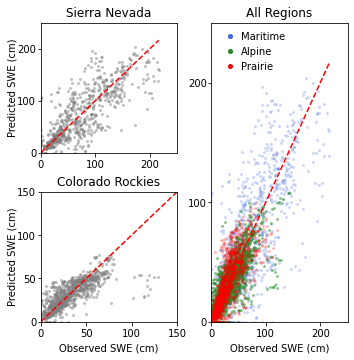

In [9]:
#Daily
FigureDeveloper.Slurm_Class_parity(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region, frequency)

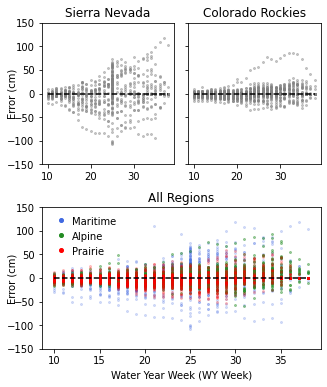

In [10]:
#Daily
FigureDeveloper.EvalPlots3(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region, 'WYWeek', 'error', 'Water Year Week (WY Week)', 'Error (cm)', 'ErrorVsWYWeek', 2, frequency)

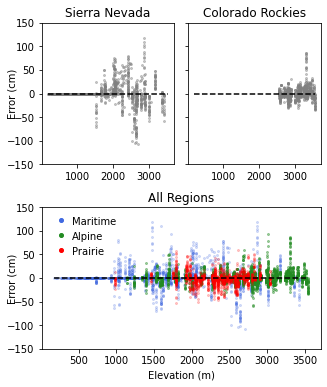

In [11]:
#Daily
FigureDeveloper.EvalPlots3(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region,'elevation_m', 'error', 'Elevation (m)', 'Error (cm)', 'ErrorVsElevation', 2, frequency)

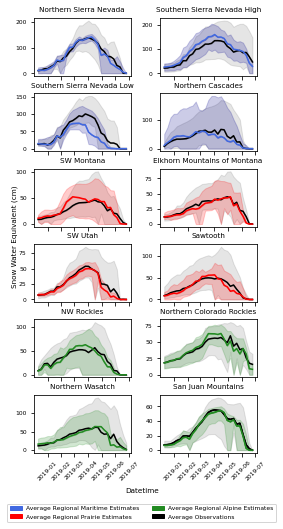

In [12]:
#Daily

Maritime_Region = ['S_Sierras_High','S_Sierras_Low', 'N_Sierras','S_Cascade',
                      'N_Cascade', 'Ca_Coast', 'Wa_Coast', 
                      'Or_Coast']

Prairie_Region  =  ['N_Yellowstone','SW_Mont', 'GBasin', 'S_Wasatch', 'Sawtooth', 'SW_Mtns']

Alpine_Region =['E_Or', 'N_Wasatch', 'E_WA_N_Id_W_Mont', 'Greater_Yellowstone', 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies',
                        'Greater_Glacier', 'SE_Co_Rockies']


importlib.reload(FigureDeveloper)

Maritime = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low','N_Cascade']
Prarie = [ 'SW_Mont', 'N_Yellowstone', 'S_Wasatch','Sawtooth']
Alpine = [ 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'N_Wasatch','SW_Co_Rockies']

plotname = 'All_Regions_TS'
save = True
RegionDict, RegionAll = FigureDeveloper.SWE_TS_plot_classes(datelist, EvalDF, Maritime, Prarie, Alpine, plotname, fontsize = 6, opacity=0.1, frequency = 'Daily', save = save)

processing predictions into geodataframe


100%|██████████| 1/1 [00:00<00:00, 36.99it/s]


creating figures for each prediction timestep


  0%|          | 0/1 [00:00<?, ?it/s]

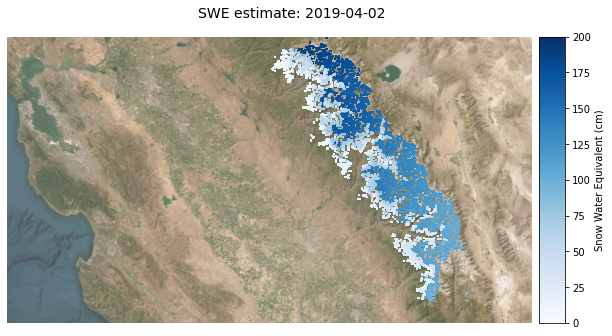

  0%|          | 0/1 [00:09<?, ?it/s]


In [13]:

importlib.reload(FigureDeveloper)
Region_list = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low']
#Get list of optional tiles here: https://contextily.readthedocs.io/en/latest/providers_deepdive.html
variant = 'World_Imagery'#   'World_Physical_Map'
date = ["2019-04-02"]
plotdf = FigureDeveloper.SSM_Fig(date, Region_list,variant,  frequency, fSCA)

In [20]:
key = f"SNODAS/SNODAS_WY2019.pkl"            
S3.meta.client.download_file(BUCKET_NAME, key,'Predictions/Hold_Out_Year/SNODAS/SNODAS_WY2019.pkl')

In [21]:
SNODAS = pd.read_pickle(r'Predictions/Hold_Out_Year/SNODAS/SNODAS_WY2019.pkl')

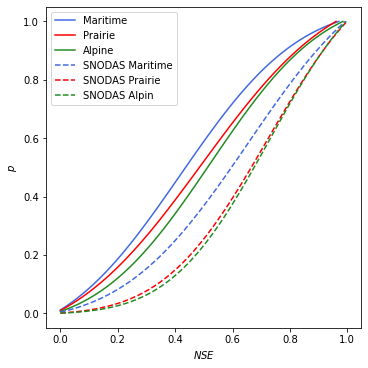

In [22]:
importlib.reload(FigureDeveloper)
#make snow class cdfs
Maritime_Region = ['S_Sierras_High','S_Sierras_Low', 'N_Sierras','S_Cascade',
                      'N_Cascade', 'Ca_Coast', 'Wa_Coast', 
                      'Or_Coast']

Prairie_Region  =  ['N_Yellowstone','SW_Mont', 'GBasin', 'S_Wasatch', 'Sawtooth', 'SW_Mtns']

Alpine_Region =['E_Or', 'N_Wasatch', 'E_WA_N_Id_W_Mont', 'Greater_Yellowstone', 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies',
                        'Greater_Glacier', 'SE_Co_Rockies']

#read in SNODAS pickle
SNODAS = pd.read_pickle(r'Predictions/Hold_Out_Year/SNODAS/SNODAS_WY2019.pkl')

#remove lat/long
for region in SNODAS.keys():
    SNODAS[region].pop('Long')
    SNODAS[region].pop('Lat')

SNODAS_MaritimeNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Maritime_Region)
SNODAS_PrarieNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Prairie_Region)
SNODAS_AlpineNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Alpine_Region)

MaritimeNSE = FigureDeveloper.slurmNSE(EvalDF, Maritime_Region)
PrarieeNSE = FigureDeveloper.slurmNSE(EvalDF, Prairie_Region)
AlpineNSE = FigureDeveloper.slurmNSE(EvalDF, Alpine_Region)

FigureDeveloper.regionCDF(MaritimeNSE, PrarieeNSE, AlpineNSE, SNODAS_MaritimeNSE, SNODAS_PrarieNSE, SNODAS_AlpineNSE, SNODAS=True, plt_save = True)

## Evaluate spatial performance of model

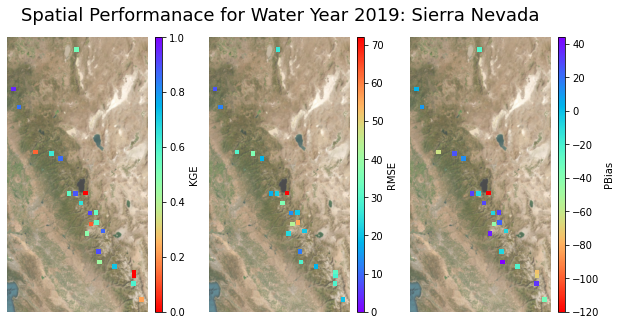

In [23]:
importlib.reload(FigureDeveloper)
Region_list = ['S_Sierras_Low', 'S_Sierras_High', 'N_Sierras']
metric = 'KGE'
fequency = 'Daily'
fSCA = True
plot_x_titloc = -1.355e7
plot_y_titloc = 5.25e6
save = True
variant = 'World_Imagery'# 
model = 'Neural Network'
plotname =  f"Spatial Performanace for Water Year 2019: Sierra Nevada"
plotdf = FigureDeveloper.SpatialPerf_Fig(Region_list,EvalDF, variant,  frequency, fSCA, plotname, plot_x_titloc, plot_y_titloc, save, model)

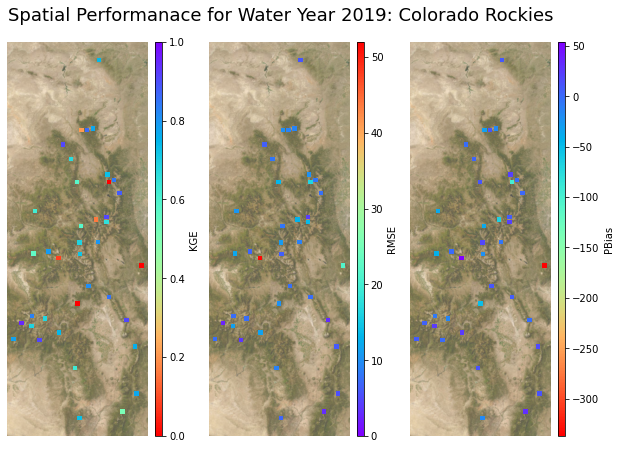

In [24]:
importlib.reload(FigureDeveloper)
Region_list =[ 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies', 'SE_Co_Rockies']
metric = 'KGE'
fequency = 'Daily'
fSCA = True
plot_x_titloc = -1.205e7
plot_y_titloc = 5.35e6
save = True
variant = 'World_Imagery'# 
model = 'Neural Network'
plotname =  f"Spatial Performanace for Water Year 2019: Colorado Rockies"
plotdf = FigureDeveloper.SpatialPerf_Fig(Region_list,EvalDF, variant,  frequency, fSCA, plotname, plot_x_titloc,plot_y_titloc , save, model)

## Evaluate to ASO obs

R2:  0.69  RMSE:  17.97  KGE:  0.65  PBias:  22.14


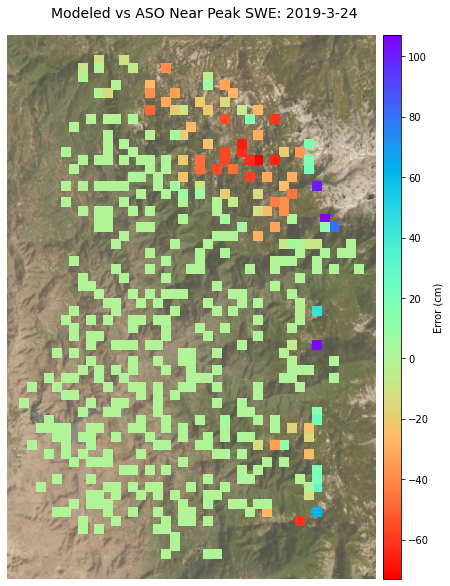

In [25]:
importlib.reload(FigureDeveloper)
ASOregions = ['S_Sierras_High', 'S_Sierras_Low']
plotname = 'Modeled vs ASO Near Peak SWE: 2019-3-24'
model = 'Nerual_Network'
plot_x_dim = -1.3245e7
variant = 'World_Imagery'# 
metric = 'KGE'
fequency = 'Daily'
save = False
FigureDeveloper.ASOError_Fig(ASOregions,EvalDF, variant,  frequency, fSCA, metric, model, plotname, plot_x_dim, save)

In [ ]:
importlib.reload(FigureDeveloper)
ASOregions = ['S_Sierras_High', 'S_Sierras_Low']
plotname = 'SNODAS vs ASO Near Peak SWE: 2019-3-24'
model = 'Nerual_Network'
plot_x_dim = -1.3245e7
variant = 'World_Imagery'# 
metric = 'KGE'
fequency = 'Daily'
save = False
FigureDeveloper.ASOError_Fig(ASOregions,SNODAS, variant,  frequency, fSCA, metric, model, plotname, plot_x_dim, save)

In [ ]:
SNODAS['S_Sierras_High']